In [2]:
import numpy as np
import matplotlib.pyplot as plt
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.14/09


DEBUG:matplotlib.backends] backend module://ipykernel.pylab.backend_inline version unknown


In [3]:
infile = '../test7/ntuple_SingleMuon_Endcap_200k.root'

In [4]:
# Takes a collection of events (say, all those with prefix 'vh_') and categorizes them so they are easier to call.
def define_collections(tree):
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  tree.define_collection(name='evt_info', prefix='ve_', size='ve_size')
  return

# Loads the particle gun, which means it loads the tree file and makes the information contained inside easily callable.
def load_pgun():
  print('[INFO] Opening file: %s' % infile)
  global infile_r
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  define_collections(tree)
  return tree

def calc_signed_rvtx(eta, phi, x0, y0, z0):
  # Propagate to station 2 (z = 850 cm)
  # Note: x0, y0, z0 in cm. Assume pT -> inf.
  zstar = 850.
  if eta < 0:
    zstar *= -1
  cot = np.sinh(eta)
  delta_r = np.abs((zstar - z0)/cot)
  xstar = x0 + np.cos(phi) * delta_r
  ystar = y0 + np.sin(phi) * delta_r
  rstar = np.hypot(xstar, ystar)
  rvtx = np.hypot(x0, y0)
  if (rstar - delta_r) <= 0.:
    rvtx *= -1
  return rvtx

In [5]:
# Python compatibility module (helps with differences between Python2 and Python3)
from six.moves import range, zip, map, filter

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

nlayers = 16  # 5 (CSC) + 4 (RPC) + 3 (GEM) + 4 (DT) stations

stations = ['ME1/1','ME1/2','ME2','ME3','ME4','RE1','RE2','RE3','RE4','GE1','GE2','ME0','MB1','MB2','MB3','MB4']

# Position of station along z-axis
z_stations = [600, 700, 830, 940, 1025, 740, 760, 975, 1060, 565, 790, 535, 300, 300, 300, 300]

# Decide EMTF hit layer number
class EMTFLayer(object):
  def __init__(self):
    lut = np.zeros((5,5,5), dtype=np.int32) - 99
    # (type, station, ring) -> layer
    lut[1,1,4] = 0  # ME1/1a
    lut[1,1,1] = 0  # ME1/1b
    lut[1,1,2] = 1  # ME1/2
    lut[1,1,3] = 1  # ME1/3
    lut[1,2,1] = 2  # ME2/1
    lut[1,2,2] = 2  # ME2/2
    lut[1,3,1] = 3  # ME3/1
    lut[1,3,2] = 3  # ME3/2
    lut[1,4,1] = 4  # ME4/1
    lut[1,4,2] = 4  # ME4/2
    lut[2,1,2] = 5  # RE1/2
    lut[2,1,3] = 5  # RE1/3
    lut[2,2,2] = 6  # RE2/2
    lut[2,2,3] = 6  # RE2/3
    lut[2,3,1] = 7  # RE3/1
    lut[2,3,2] = 7  # RE3/2
    lut[2,3,3] = 7  # RE3/3
    lut[2,4,1] = 8  # RE4/1
    lut[2,4,2] = 8  # RE4/2
    lut[2,4,3] = 8  # RE4/3
    lut[3,1,1] = 9  # GE1/1
    lut[3,2,1] = 10 # GE2/1
    lut[4,1,1] = 11 # ME0
    lut[0,1,1] = 12 # MB1
    lut[0,2,1] = 13 # MB2
    lut[0,3,1] = 14 # MB3
    lut[0,4,1] = 15 # MB4
    self.lut = lut

  def __call__(self, hit):
    index = (hit.type, hit.station, hit.ring)
    emtf_layer = self.lut[index]
    return emtf_layer

find_emtf_layer = EMTFLayer()

# Decide EMTF legit hit
def is_emtf_legit_hit(hit):
  def check_bx(hit):
    if hit.type == kCSC:
      return hit.bx in (-1,0)
    elif hit.type == kDT:
      return hit.bx in (-1,0)
    else:
      return hit.bx == 0
  def check_phi(hit):
    if hit.type == kME0:
      return hit.emtf_phi > 0
    elif hit.type == kDT:
      return hit.emtf_phi > 0
    else:
      return True
  return check_bx(hit) and check_phi(hit)

In [6]:
def calc_etastar_from_eta(invpt, eta, phi, x0, y0, z0, zstar=850.):
  # Propagate to station 2 (z = 850 cm)
  # Note: x0, y0, z0 in cm. Assume pT -> inf.
  if eta < 0:
    zstar *= -1
  # Assume a simplified magnetic field where it is 4T (or 3.811T)
  # inside the solenoid and 0T outside (boundary at z = 650 cm)
  zstar_4T = 650.
  if eta < 0:
    zstar_4T *= -1
  B = 3.811
  R = -1.0 / (0.003 * B * invpt)            # R = -pT/(0.003 q B)  [cm]
  cot = np.sinh(eta)
  if np.abs(zstar_4T) < np.abs(zstar):
    arg_term_4T = np.abs((zstar_4T - z0)/cot)                 # with magfield
    sin_term_4T = (2 * R) * np.sin(arg_term_4T/(2 * R))       # with magfield
    cos_term_4T = (2 * R) * (1 - np.cos(arg_term_4T/(2 * R))) # with magfield
    arg_term_0T = np.abs((zstar - zstar_4T)/cot)              # without magfield
    sin_term_0T = arg_term_0T                                 # without magfield
    cos_term_0T = 0                                           # without magfield
  else:
    # Also need to check for the boundary at r, ignore for now
    arg_term_4T = np.abs((zstar - z0)/cot)                    # with magfield
    sin_term_4T = (2 * R) * np.sin(arg_term_4T/(2 * R))       # with magfield
    cos_term_4T = (2 * R) * (1 - np.cos(arg_term_4T/(2 * R))) # with magfield
    arg_term_0T = 0                                           # without magfield
    sin_term_0T = 0                                           # without magfield
    cos_term_0T = 0                                           # without magfield
  phistar_4T = phi + arg_term_4T/(2 * R)  # phi at the boundary where 4T -> 0T
  xstar = x0 + np.cos(phi) * sin_term_4T - np.sin(phi) * cos_term_4T + \
          np.cos(phistar_4T) * sin_term_0T - np.sin(phistar_4T) * cos_term_0T
  ystar = y0 + np.sin(phi) * sin_term_4T + np.cos(phi) * cos_term_4T + \
          np.sin(phistar_4T) * sin_term_0T + np.cos(phistar_4T) * cos_term_0T
  rstar = np.hypot(xstar, ystar)
  cotstar = zstar/rstar
  etastar = np.arcsinh(cotstar)
  return etastar

In [7]:
# Main analysis

def analysis(d0min=0,d0max=0,pileup=0):
  # Load tree
  if pileup == 200:
    tree = load_pgun_PU200()
  else:
    tree = load_pgun()
  
  # Event range
    maxEvents = int(tree.GetEntries())
#   maxEvents = 100000
#   maxEvents = 10000
  
  # Output
  out_part, out_hits = [], []
  part_eta, part_invpt, part_etastar = [], [], []
  
  # __________________________________________________________________________
  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    if (ievt % 10000 == 0) and maxEvents < 1000000:  print("Processing event: {0}".format(ievt))
    if (ievt % 100000 == 0) and maxEvents > 1000000:  print("Processing event: {0}".format(ievt))
    
    # Skip events with very few hits
    if not len(evt.hits) >= 2:
      continue
    
    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kDT and (hit.station == 1 or hit.station == 2):
        has_ME1 = True
        break
    #if not has_ME1:
    #  continue
    
    try:
        part = evt.particles[0]  # particle gun
    except IndexError:
        continue
    
    part.invpt = np.true_divide(part.q, part.pt)
    invpt = np.true_divide(part.q, part.pt)
    
#     # Ignoring cuts on pT for pT analysis.
#     # Skip low pT muons
#     if part.pt < 20:
#         continue
    
      # Skip |eta|<1.2 muons
    if abs(part.eta) < 1.2:
      continue
    
    etastar = np.ones((nlayers,))
    for i in xrange(nlayers):
      etastar[i]=calc_etastar_from_eta(invpt, part.eta, part.phi, part.vx, part.vy, part.vz, z_stations[i])

#     # Use positive endcap only
#     f = lambda hit: hit.endcap == 1
#     selected_hits = filter(f, evt.hits)
    selected_hits = evt.hits
    
    # Use sim_tp == 1 only
    f = lambda hit: ((hit.type == kCSC) and (hit.sim_tp1 == 0 or hit.sim_tp1 == 1) and (hit.sim_tp1 == hit.sim_tp2)) or \
                    ((hit.type != kCSC) and (hit.sim_tp1 == 0 or hit.sim_tp1 == 1)) or \
                    ((hit.type == kME0) and False)
    selected_hits = filter(f, selected_hits)
    
    # Check for boolean indicating a trigger primitive in the station. 
    x_mask_array = np.ones((nlayers,), dtype=np.int32)
    for ihit, hit in enumerate(selected_hits):
      lay = find_emtf_layer(hit)
      if is_emtf_legit_hit(hit):
        x_mask_array[lay] = 0.0
    
    # Output
    part_etastar.append(etastar)
    part_invpt.append(part.invpt)
    part_eta.append(part.eta)
    out_hits.append(x_mask_array)
    
    
    continue  # end loop over events

  print("DONE")
  return np.asarray(part_eta), np.asarray(part_invpt), np.asarray(part_etastar), np.asarray(out_hits)

In [8]:
# Run analysis
%time
out_part_eta, out_part_invpt, out_part_etastar, out_hits = analysis()
print out_part_eta.shape, out_part_invpt.shape, out_part_etastar.shape, out_hits.shape, out_hits.dtype

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs
[INFO] Opening file: ../test7/ntuple_SingleMuon_Endcap_200k.root
Processing event: 0
Processing event: 10000
Processing event: 20000
Processing event: 30000
Processing event: 40000
Processing event: 50000
Processing event: 60000
Processing event: 70000
Processing event: 80000
Processing event: 90000
Processing event: 100000
Processing event: 110000
Processing event: 120000
Processing event: 130000
Processing event: 140000
Processing event: 150000
Processing event: 160000
Processing event: 170000
Processing event: 180000
Processing event: 190000
DONE
(191144,) (191144,) (191144, 16) (191144, 16)

NameError: name 'out_part' is not defined

In [10]:
# Applying a cut on pT (throw out anything with pT < 20 GeV)
pt_mask = np.asarray([abs(i) < 0.05 for i in out_part_invpt])
pt_mask = pt_mask.astype(np.bool)

pt_cut_eta     = out_part_eta[pt_mask]
pt_cut_etastar = out_part_etastar[pt_mask]
pt_cut_hits    = out_hits[pt_mask]

In [11]:
prefix  = 'prompt_'
version = '_v2' # Updated after v1 was created (v2 does not currently exist)

np.savez(prefix + 'uncut' + version,
         out_part_eta, out_part_etastar,  out_hits,
         name0 = 'eta', name1 = 'etastar', name2 = 'out_hits')

np.savez(prefix + 'pt_cut' + version,
         pt_cut_eta,    pt_cut_etastar,    pt_cut_hits,
         name0 = 'eta', name1 = 'etastar', name2 = 'out_hits')

In [12]:
# Styling
plt.style.use('tdrstyle.mplstyle')
import matplotlib as mpl

##### 1d Histograms ######

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipykernel/4.10.0/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
DEBUG:matplotlib.font_manager] findfont: Matching :family=DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=9.163 to DejaVu Sans (u'/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager] findfont: Matching :family=DejaVu Sans:style=normal:variant=normal:weight=bold:stretch=normal:size=18.0 to DejaVu Sans (u'/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2

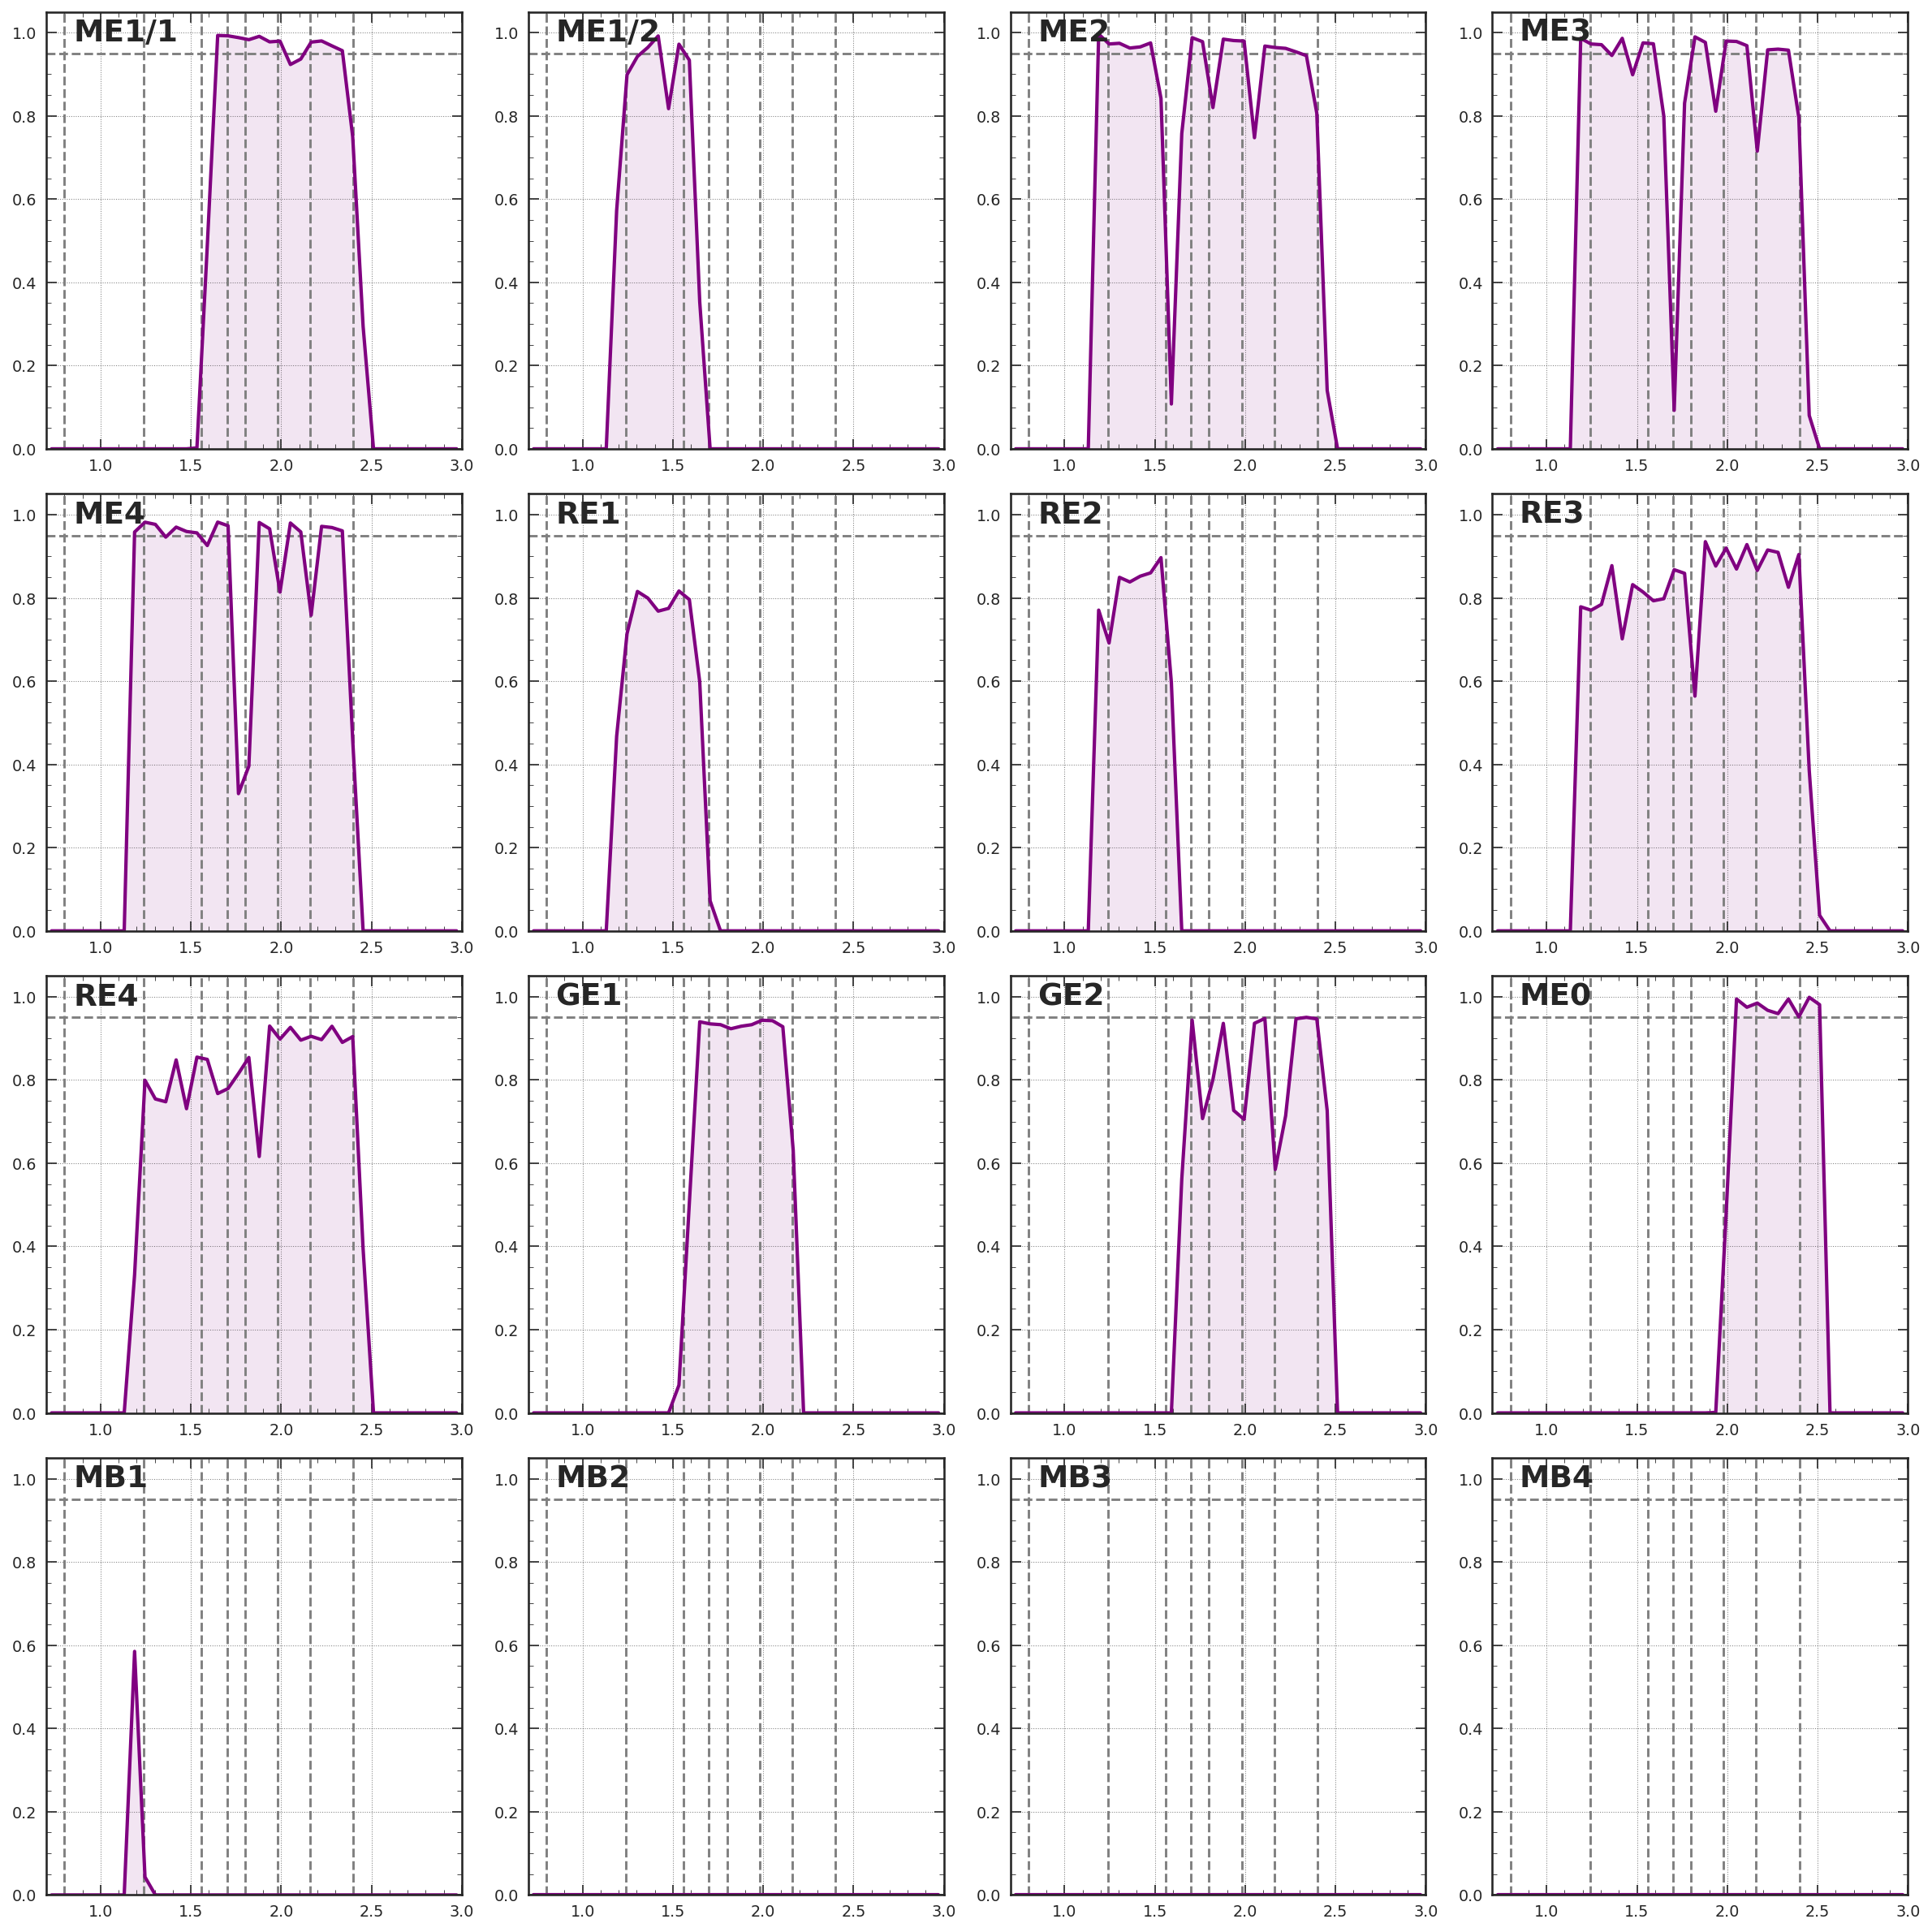

In [13]:
fig, axs = plt.subplots(nlayers/4, 4, figsize=(4*4,(nlayers/4)*4), tight_layout=True)


# y_etastar = out_part_etastar.copy()


xmin, xmax = 0.7, 3.0
ymin, ymax = 0.0, 1.05

nbinsx = 40

for i in xrange(nlayers):

  xdata = pt_cut_etastar[:,i].copy()
  x_mask = pt_cut_hits.copy().astype(np.bool)
  mask = x_mask[...,i]
  valid = ~mask  # valid hits

  denom_hist, edges = np.histogram(np.abs(xdata), bins=nbinsx, range=(xmin,xmax))
  num_hist, edges = np.histogram(np.abs(xdata[valid]), bins=nbinsx, range=(xmin,xmax))
  eff_hist = np.where(denom_hist != 0, np.true_divide(num_hist, denom_hist), 0)

  xdata = (edges[1:] + edges[:-1])/2
  ydata = eff_hist

  ax = axs[i/4,i%4]
  ax.text(0.85,0.98,stations[i],weight='bold',fontsize=18)
  ax.errorbar(xdata, ydata, color='purple', marker=',', capsize=0, lw=2)
  ax.fill_between(xdata, 0, ydata, color='purple', alpha=0.1)

  for x in [0.8, 1.24, 1.56, 1.7, 1.8, 1.98, 2.16, 2.4]:  # vertical lines
    ax.plot([x,x], [ymin,ymax], '--', color='grey')
  for y in [0.95]:  # horizontal lines
    ax.plot([xmin,xmax], [y,y], '--', color='grey')
  ax.set_xlim(xmin,xmax)
  ax.set_ylim(ymin,ymax)

plt.show()

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipykernel/4.10.0/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


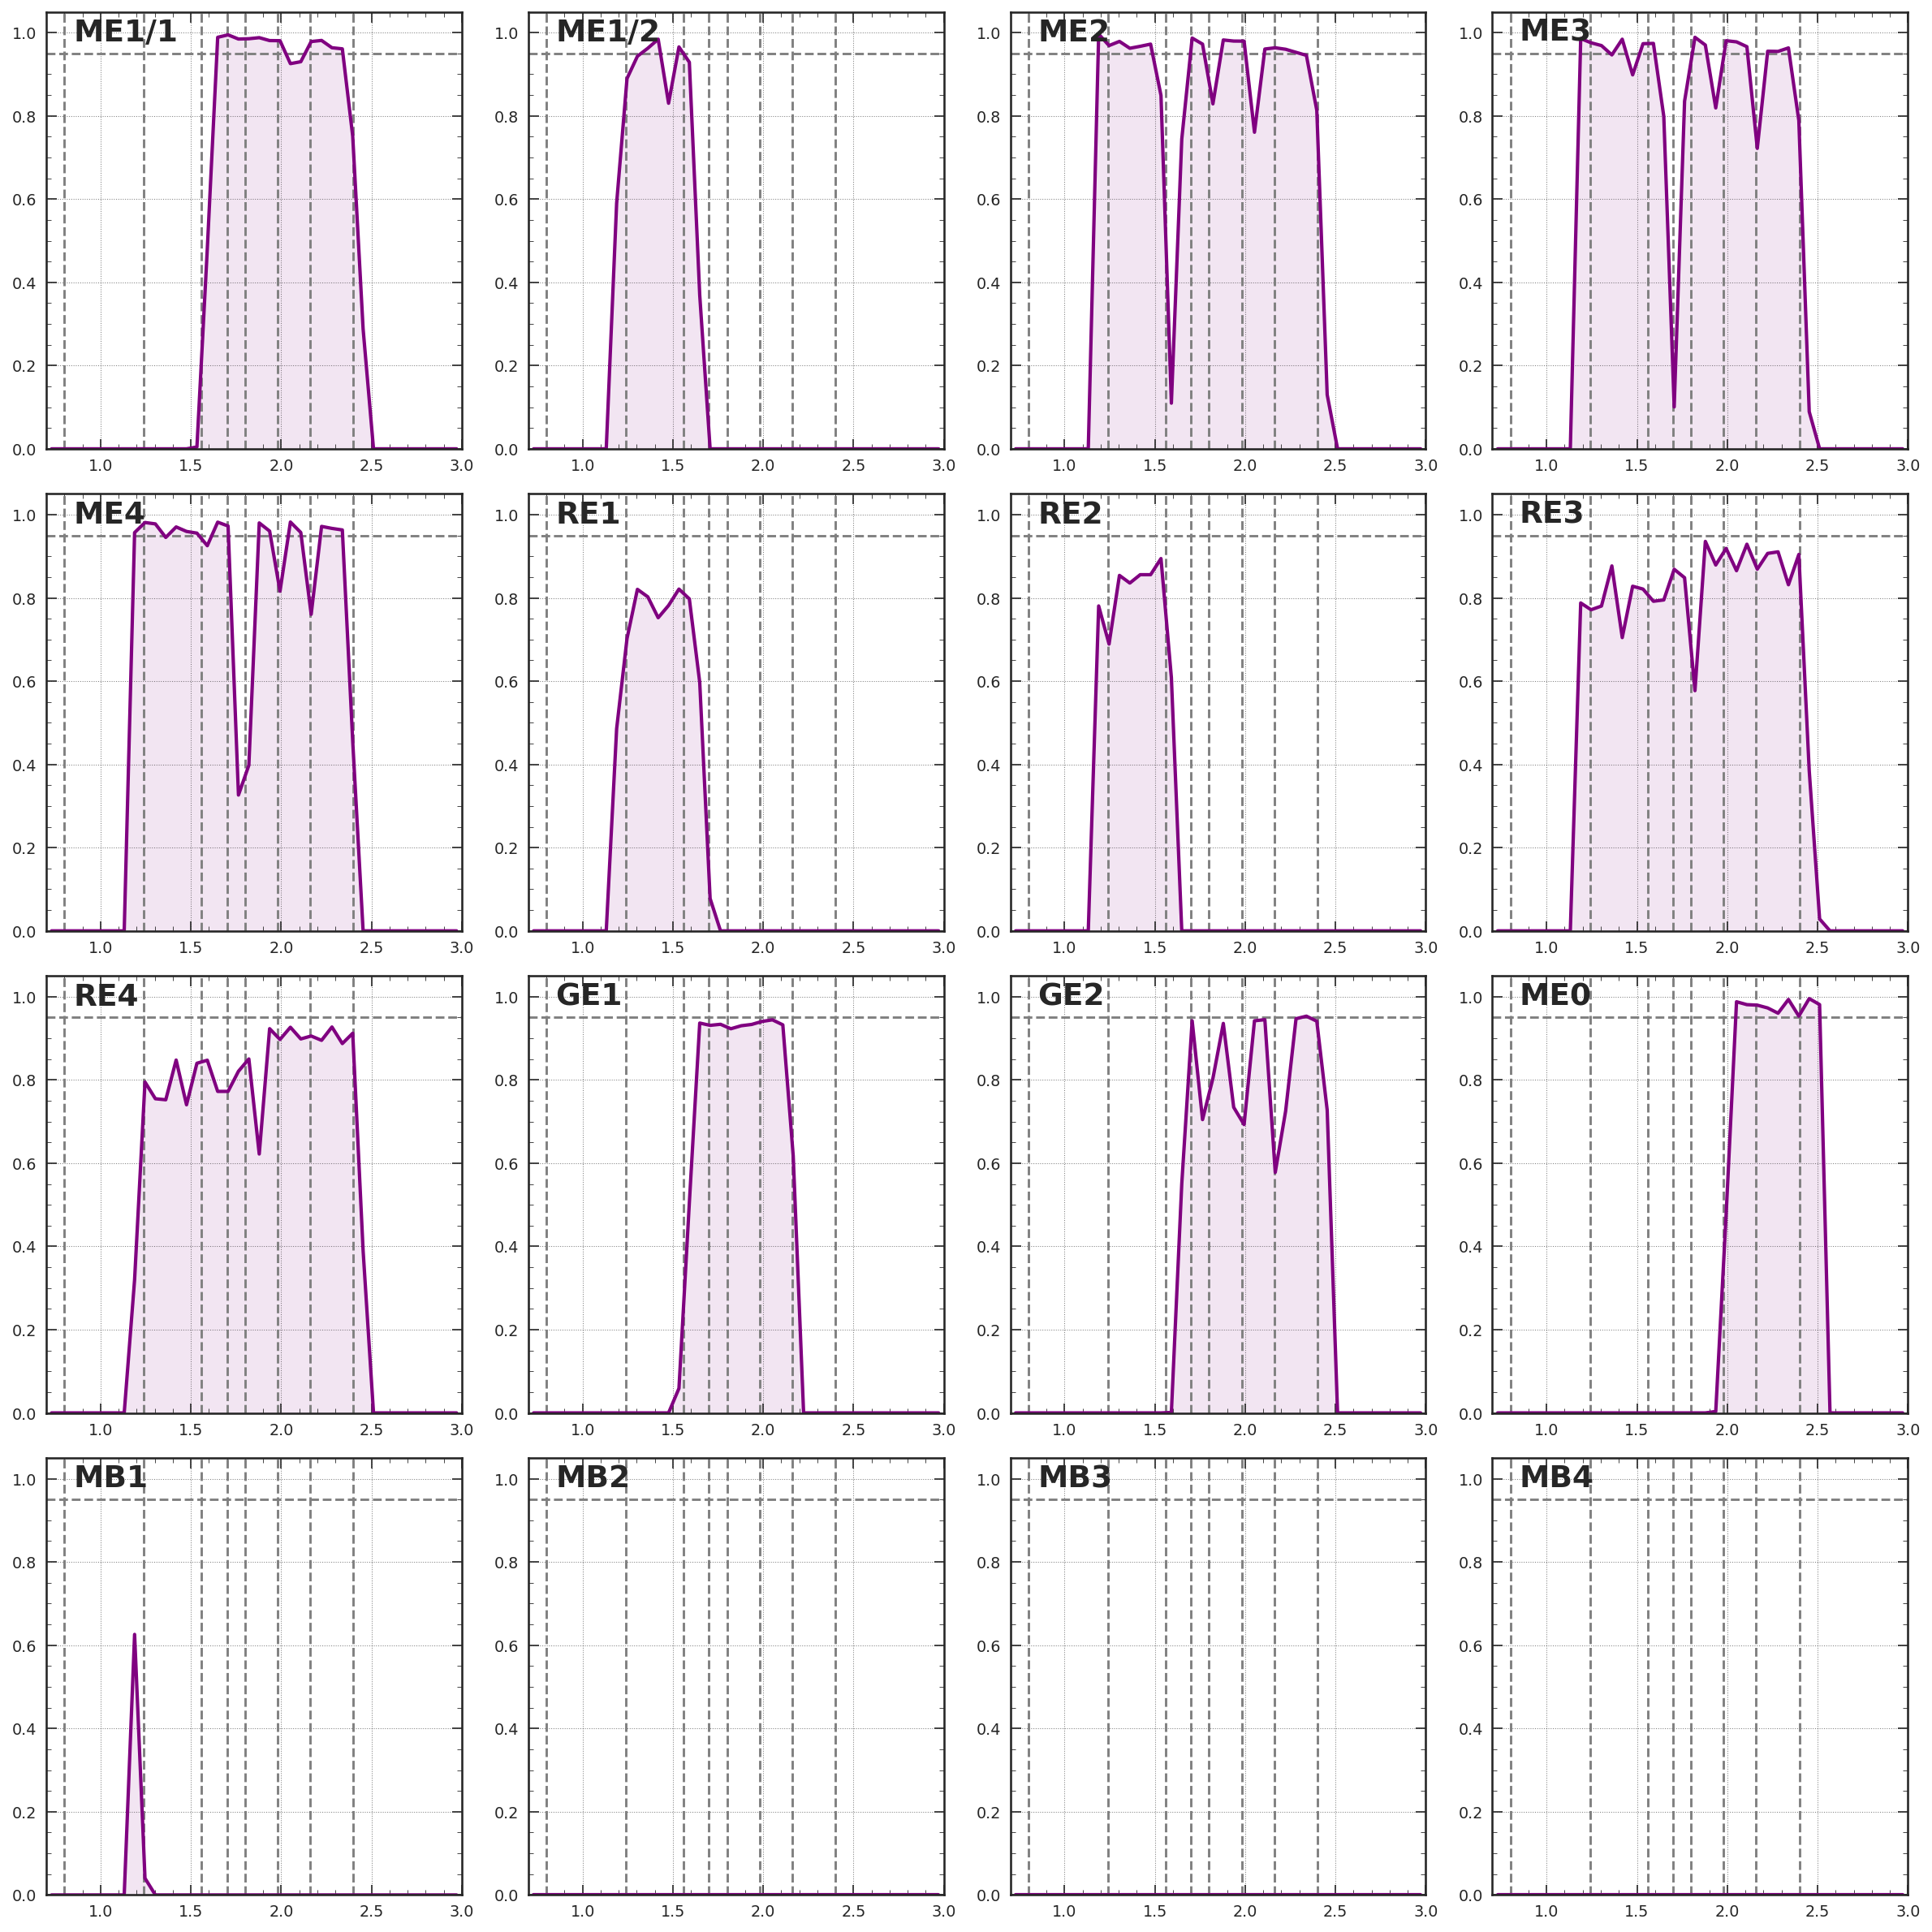

In [14]:
fig, axs = plt.subplots(nlayers/4, 4, figsize=(4*4,(nlayers/4)*4), tight_layout=True)


# y_etastar = out_part_etastar.copy()


xmin, xmax = 0.7, 3.0
ymin, ymax = 0.0, 1.05

nbinsx = 40

for i in xrange(nlayers):

  xdata = pt_cut_eta.copy()
  x_mask = pt_cut_hits.copy().astype(np.bool)
  mask = x_mask[...,i]
  valid = ~mask  # valid hits

  denom_hist, edges = np.histogram(np.abs(xdata), bins=nbinsx, range=(xmin,xmax))
  num_hist, edges = np.histogram(np.abs(xdata[valid]), bins=nbinsx, range=(xmin,xmax))
  eff_hist = np.where(denom_hist != 0, np.true_divide(num_hist, denom_hist), 0)

  xdata = (edges[1:] + edges[:-1])/2
  ydata = eff_hist

  ax = axs[i/4,i%4]
  ax.text(0.85,0.98,stations[i],weight='bold',fontsize=18)
  ax.errorbar(xdata, ydata, color='purple', marker=',', capsize=0, lw=2)
  ax.fill_between(xdata, 0, ydata, color='purple', alpha=0.1)

  for x in [0.8, 1.24, 1.56, 1.7, 1.8, 1.98, 2.16, 2.4]:  # vertical lines
    ax.plot([x,x], [ymin,ymax], '--', color='grey')
  for y in [0.95]:  # horizontal lines
    ax.plot([xmin,xmax], [y,y], '--', color='grey')
  ax.set_xlim(xmin,xmax)
  ax.set_ylim(ymin,ymax)

plt.show()

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipykernel/4.10.0/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipykernel/4.10.0/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipykernel/4.10.0/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipykernel/4.10.0/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


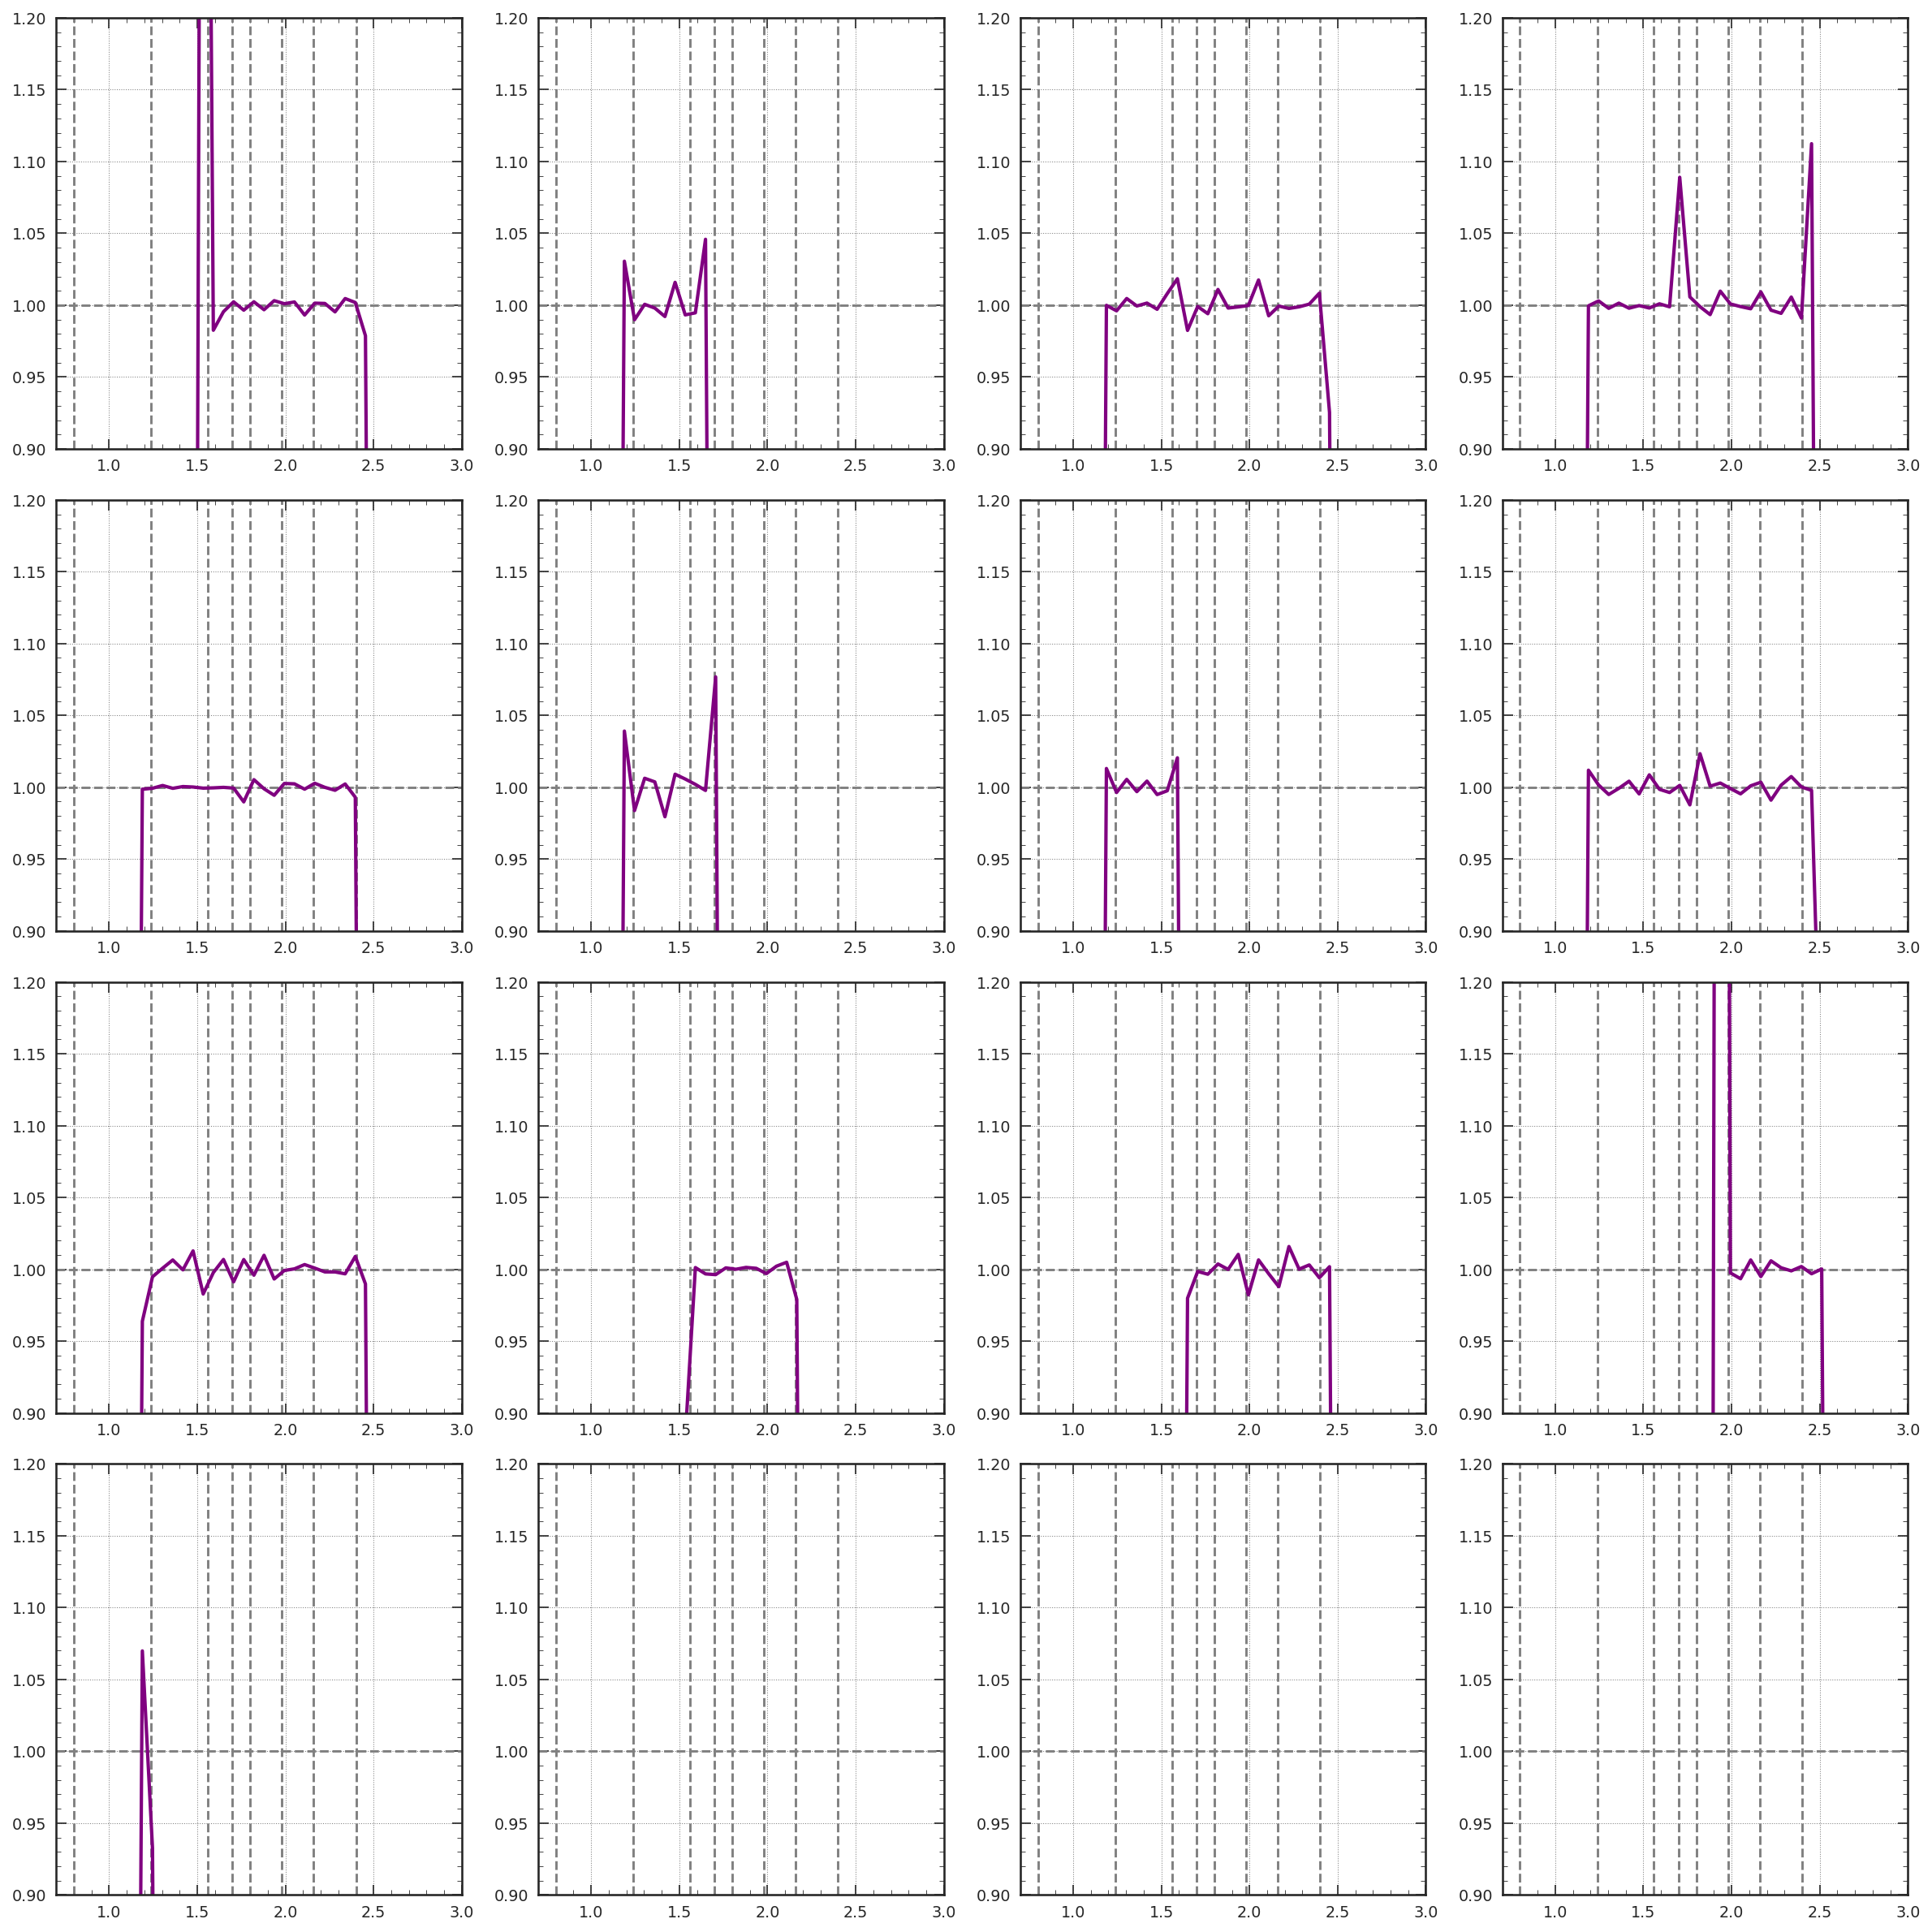

In [27]:
fig, axs = plt.subplots(nlayers/4, 4, figsize=(4*4,(nlayers/4)*4), tight_layout=True)

# Comparing efficiencies in eta vs. etastar

xmin, xmax = 0.7, 3.0
ymin, ymax = 0.9, 1.2

nbinsx = 40

for i in xrange(nlayers):

  xdata1 = pt_cut_eta.copy()
  xdata2 = pt_cut_etastar[:,i].copy()
  x_mask = pt_cut_hits.copy().astype(np.bool)
  mask = x_mask[...,i]
  valid = ~mask  # valid hits

  denom_hist1, edges = np.histogram(np.abs(xdata1), bins=nbinsx, range=(xmin,xmax))
  num_hist1, edges = np.histogram(np.abs(xdata1[valid]), bins=nbinsx, range=(xmin,xmax))
  eff_hist1 = np.where(denom_hist1 != 0, np.true_divide(num_hist1, denom_hist1), 0)
  
  denom_hist2, edges = np.histogram(np.abs(xdata2), bins=nbinsx, range=(xmin,xmax))
  num_hist2, edges = np.histogram(np.abs(xdata2[valid]), bins=nbinsx, range=(xmin,xmax))
  eff_hist2 = np.where(denom_hist2 != 0, np.true_divide(num_hist2, denom_hist2), 0)
  
  ratio_eta2etastar = np.where(eff_hist2 != 0, np.true_divide(eff_hist1, eff_hist2), 0)

  xdata = (edges[1:] + edges[:-1])/2
  ydata = ratio_eta2etastar

  ax = axs[i/4,i%4]
#   ax.text(0.85,0.98,stations[i],weight='bold',fontsize=18)
  ax.errorbar(xdata, ydata, color='purple', marker=',', capsize=0, lw=2)
#   ax.fill_between(xdata, 0, ydata, color='purple', alpha=0.1)

  for x in [0.8, 1.24, 1.56, 1.7, 1.8, 1.98, 2.16, 2.4]:  # vertical lines
    ax.plot([x,x], [ymin,ymax], '--', color='grey')
  for y in [1.0]:  # horizontal lines
    ax.plot([xmin,xmax], [y,y], '--', color='grey')
  ax.set_xlim(xmin,xmax)
  ax.set_ylim(ymin,ymax)

plt.show()

##### 2d Histograms #####

In [28]:
def my_hist2d(eff_hist, xedges, yedges, ax, cmap=None, colorbar=False):
  xdata = (xedges[1:] + xedges[:-1])/2
  ydata = (yedges[1:] + yedges[:-1])/2
  xv, yv = np.meshgrid(xdata, ydata)
  x = xv.ravel()
  y = yv.ravel()
  z = eff_hist.T.ravel()
  h, edges, yedges, image = ax.hist2d(x, y, weights=z, bins=(xedges, yedges), cmap=cmap, vmin=0.0, vmax=1.05)
  if colorbar:
    cb = plt.colorbar(image, ax=ax)#, norm=mpl.colors.Normalize(vmin=0.0, vmax=1.0),extend='both')
  return h, edges, yedges, image

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipykernel/4.10.0/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


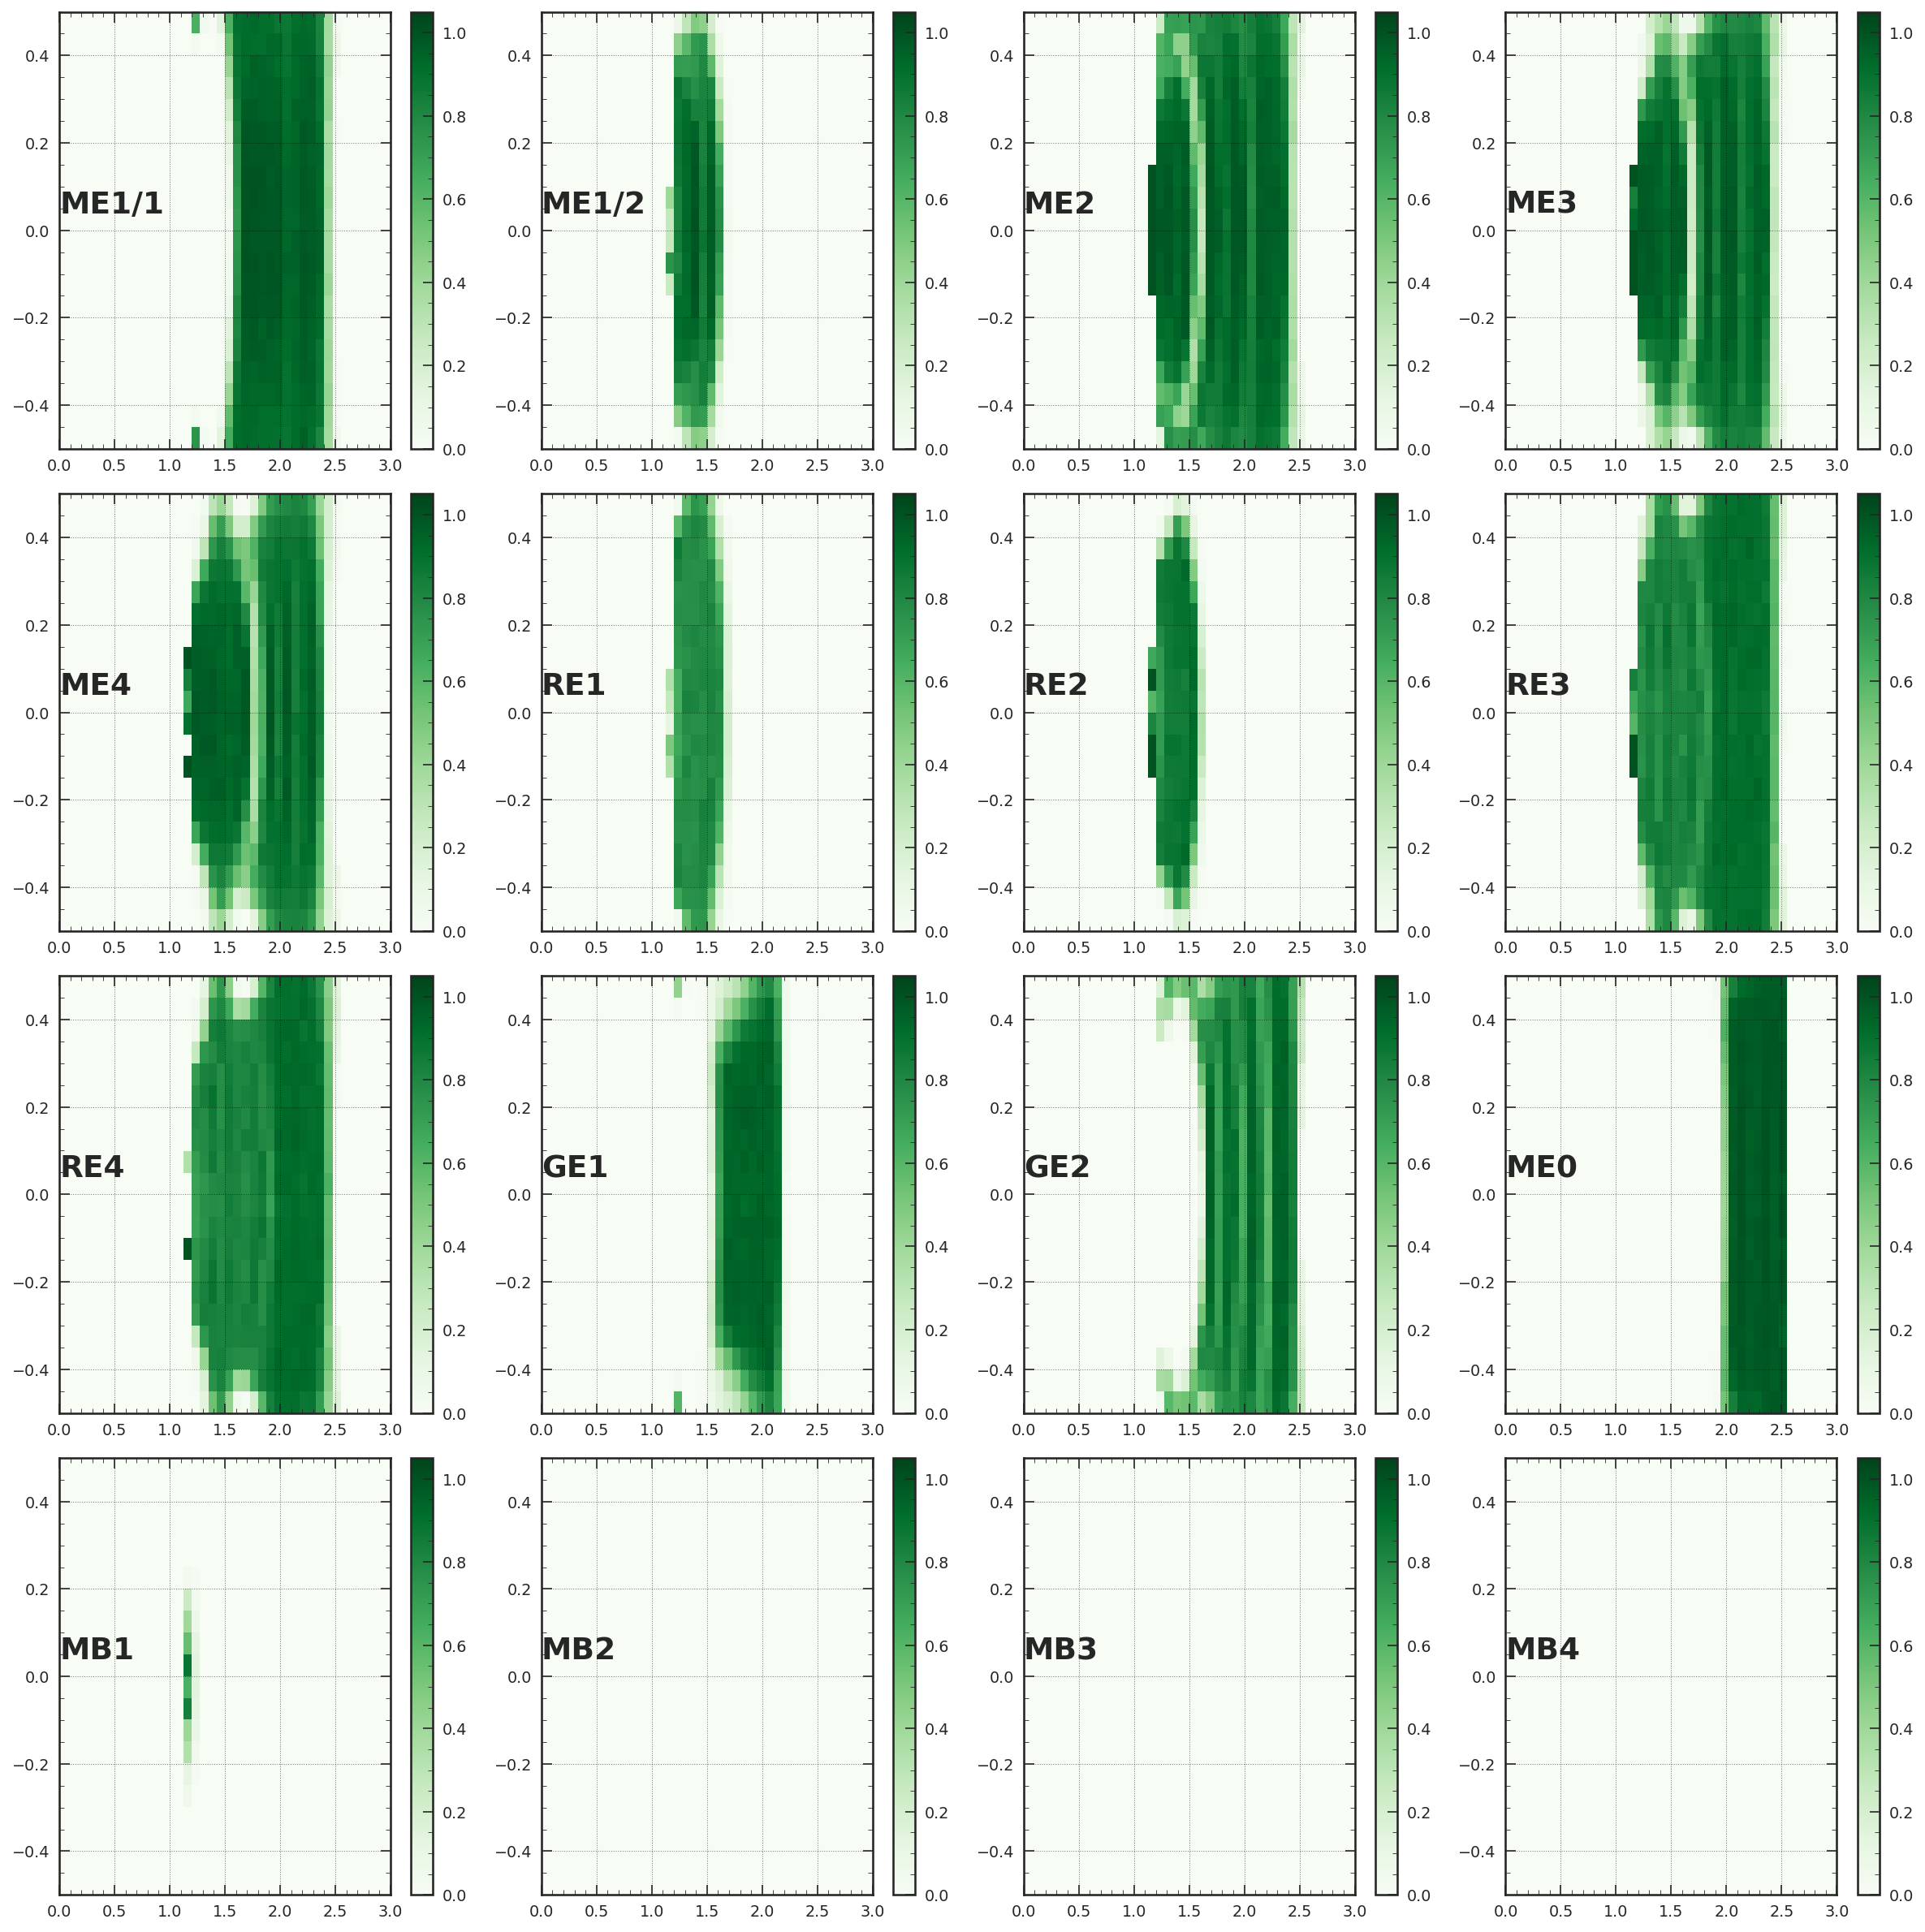

In [29]:
# 2d efficiency plots

# Define figure and create 4 by 4 subplots (16 stations)
fig, axs = plt.subplots(nlayers/4, 4, figsize=(4*4,(nlayers/4)*4), tight_layout=True)

rangeshape = [[0.0,3.0],[min(ydata),max(ydata)]]
xbins, ybins = 40, 20

for i in xrange(nlayers):

  xdata = out_part_etastar[:,i].copy()
  x = xdata[~out_hits.astype(np.bool)[:,i]]
  ydata = out_part_invpt.copy()
  y = ydata[~out_hits.astype(np.bool)[:,i]]
  x_mask = out_hits.copy()
  mask = x_mask[...,i]
  valid = ~mask  # valid hits

  # 2d histograms
  denom_hist, xedges, yedges = np.histogram2d(np.abs(xdata), ydata, bins=(xbins,ybins), range=rangeshape)
  num_hist, xedges, yedges = np.histogram2d(np.abs(x), y, bins=(xbins,ybins), range=rangeshape)
  eff_hist = np.where(denom_hist != 0, np.true_divide(num_hist, denom_hist), 0)

  # Styling
  from matplotlib.colors import ListedColormap
  my_cmap = ListedColormap(plt.cm.viridis.colors, name='viridis_mod')
  my_cmap.set_under('w',1)

  ax = axs[i/4,i%4]
  _ = my_hist2d(eff_hist, xedges, yedges, ax=ax, cmap=plt.cm.get_cmap('Greens'), colorbar=True) # 2d hist
  ax.text(rangeshape[0][0],0.04,stations[i],weight='bold',fontsize=18) # 1d and 2d hist

  for x in [0.8, 1.24, 1.56, 1.7, 1.8, 1.98, 2.16, 2.4]:  # vertical lines
      ax.plot([x,x], [rangeshape[1][0],rangeshape[1][1]], '--', color='grey')
plt.show()